📊 Демонстрация LSTM модели с Attention Mask для предсказания числовых рядов
===

## 🧠 Архитектура модели

Данная модель представляет собой последовательную нейросетевую архитектуру для обработки временных рядов и предсказания следующего элемента последовательности. Основные компоненты модели:

* **Линейный слой (`input_linear`)** — преобразует скалярный входной признак в вектор признаков размерности `hidden_dim`, обеспечивая более богатое представление данных для последующей обработки.

* **Слой нормализации (`LayerNorm`) и активация ReLU** — стабилизируют и улучшают процесс обучения, вводя нормализацию признаков и нелинейность.

* **LSTM (Long Short-Term Memory)** — рекуррентная нейросеть, способная учитывать долгосрочные зависимости во входной последовательности. Архитектура позволяет настраивать число слоёв, использование dropout, а также режим bidirectional (двунаправленный LSTM), при котором последовательность анализируется как в прямом, так и в обратном направлении.

* **Механизм внимания (`Attention`)** — вычисляет взвешенную сумму скрытых состояний LSTM, где веса определяют релевантность каждого временного шага для текущей задачи предсказания. Это позволяет модели сосредоточиться на наиболее информативных участках последовательности.

* **Линейный выходной слой (`output_linear`)** — преобразует итоговый контекст из слоя внимания в конечное числовое предсказание.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim: int = 1, hidden_dim: int = 64, num_layers: int = 1, dropout: float = 0.1, bidirectional=False):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.ln = nn.LayerNorm(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim,
                            num_layers=num_layers, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0,
                            bidirectional=bidirectional)
        attn_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.attention = Attention(attn_input_dim)
        self.output_linear = nn.Linear(attn_input_dim, 1)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        x = x.unsqueeze(-1)
        x = self.input_linear(x)
        x = self.ln(x)
        x = F.relu(x)

        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out, mask)
        output = self.output_linear(context)

        return output, attn_weights

    def count_parameters(self, trainable_only=True):
        if trainable_only:
            return sum(p.numel() for p in self.parameters() if p.requires_grad)
        else:
            return sum(p.numel() for p in self.parameters())

    def get_config(self):
        return {
            "input_dim": self.input_linear.in_features,
            "hidden_dim": self.lstm.hidden_size,
            "num_layers": self.lstm.num_layers,
            "dropout": self.lstm.dropout,
            "bidirectional": self.lstm.bidirectional
        }

### 🔍 Механизм внимания

Внимание формируется следующим образом:

Для каждого временного шага $t$ скрытое состояние LSTM $h_t$ проходит через линейный слой, вычисляющий скалярный скор (score):

$$
\text{score}_t = \mathbf{W} h_t + b,
$$

где $\mathbf{W}$ и $b$ — обучаемые параметры.

Далее применяется функция softmax для нормализации скорингов по всем временным шагам, что формирует распределение весов внимания $\alpha_t$:

$$
\alpha_t = \frac{\exp(\text{score}_t / T)}{\sum_{k} \exp(\text{score}_k / T)},
$$

где $T$ — параметр температуры (здесь равен 1), контролирующий «остроту» распределения.

Итоговый контекст вычисляется как взвешенная сумма скрытых состояний:

$$
\text{context} = \sum_t \alpha_t h_t.
$$

### Значение внимания в модели

Использование механизма внимания позволяет эффективно выделять ключевые временные шаги, оказывающие наибольшее влияние на предсказание. Это повышает интерпретируемость модели и улучшает качество предсказаний, особенно при работе с длительными последовательностями и сложными зависимостями.

In [2]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.temperature = 1.0

    def forward(self, encoder_outputs, mask=None):
        attn_scores = self.attn(encoder_outputs).squeeze(-1)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores / self.temperature, dim=-1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights

## 📊 Визуализация архитектуры модели


(process:15404): Pango-WARNING **: 22:08:09.579: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


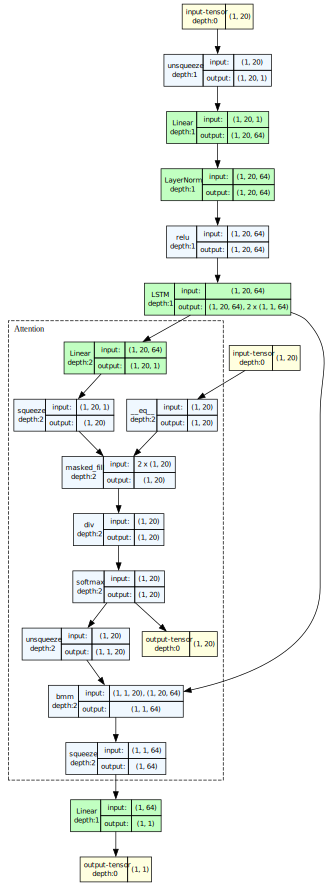

In [3]:
from torchview import draw_graph
import torch

model = LSTMWithAttention()
x = torch.randn(1, 20)
mask = torch.ones_like(x).bool()

draw_graph(model, input_data=(x, mask), expand_nested=True).visual_graph

## Обучение модели

In [1]:
from data.generators import generate_data
from data.dataset import build_dataloaders

data, labels, masks = generate_data(num_samples=100_000)
train_loader, val_loader, test_loader = build_dataloaders(data, labels, masks, split=(0.8, 0.1, 0.1))

Generating sequences: 100%|██████████| 100000/100000 [00:06<00:00, 15221.99it/s]


In [22]:
import torch
from training.trainer import train_model

print('Torch CUDA status: \n\t%s' %
      '✅ Available' if torch.cuda.is_available() else '❌ NOT available', '\n')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Обучение
trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=2_000,
    patience=10,
    lr=1e-3,
    device=device,
    checkpoint_every=25
)

Torch CUDA status: 
	✅ Available 



[Epoch 1] Train Loss: 0.0246 | Val Loss: 0.0273
Example input: [ 0.0000000e+00  6.1803401e-01  1.1755705e+00  1.6180340e+00
  1.9021131e+00  2.0000000e+00  1.9021131e+00  1.6180340e+00
  1.1755705e+00  6.1803401e-01  2.4492937e-16 -6.1803401e-01
 -1.1755705e+00 -1.6180340e+00 -1.9021131e+00 -2.0000000e+00
 -1.9021131e+00 -1.6180340e+00 -1.1755705e+00 -6.1803401e-01]
Example target: -4.898587410340671e-16
Example prediction: 0.002840787172317505


KeyboardInterrupt: 

In [15]:
torch.save({
    "config": trained_model.get_config(),
    "state_dict": trained_model.state_dict(),
}, "weights/demo.pt")
torch.save(trained_model, "saved_models/demo_full.pt")
print("Model saved ✅")

Model saved ✅


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_attention_heatmaps(attn_weights, masks, n_samples=4):
    """
    Визуализирует attention weights и маски для нескольких примеров из батча.

    attn_weights: torch.Tensor, shape [batch_size, seq_len]
    masks: torch.Tensor, shape [batch_size, seq_len] (bool or 0/1)

    n_samples: сколько примеров из батча показать (макс n_samples)
    """
    batch_size = attn_weights.shape[0]
    n_samples = min(n_samples, batch_size)

    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3 * n_samples))

    if n_samples == 1:
        axes = [axes]

    for i in range(n_samples):
        attn = attn_weights[i].detach().cpu().numpy()
        mask = masks[i].detach().cpu().numpy()

        # Attention weights heatmap
        axes[i][0].imshow(attn[np.newaxis, :], aspect='auto', cmap='viridis')
        axes[i][0].set_title(f"Attention weights (sample {i})")
        axes[i][0].set_ylabel('Attention')
        axes[i][0].set_xlabel('Sequence Step')
        axes[i][0].set_yticks([])

        # Mask heatmap (черно-белая)
        axes[i][1].imshow(mask[np.newaxis, :], aspect='auto', cmap='gray_r')
        axes[i][1].set_title(f"Attention mask (sample {i})")
        axes[i][1].set_ylabel('Mask')
        axes[i][1].set_xlabel('Sequence Step')
        axes[i][1].set_yticks([])

    plt.tight_layout()
    plt.show()

# Загрузка чекпоинта
checkpoint = torch.load("weights/demo.pt", map_location='cpu')
config = checkpoint["config"]

# Восстановление модели
model = LSTMWithAttention(**config)
model.load_state_dict(checkpoint["state_dict"])

# Определяем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Берем батч из тестового даталоадера
example_data, example_mask, example_labels = next(iter(test_loader))

# Переносим данные на девайс
example_data = example_data.to(device)
example_mask = example_mask.to(device)
example_labels = example_labels.to(device)

# Отключаем градиенты и делаем предсказание
model.eval()
with torch.no_grad():
    outputs, attention_weights = model(example_data, example_mask)

print("Output shape:", outputs.shape)
print("Attention weights shape:", attention_weights.shape)

# Визуализируем (в plot_attention_heatmaps есть .cpu())
plot_attention_heatmaps(attention_weights, example_mask, n_samples=4)
